<a href="https://colab.research.google.com/github/KgadiKatse/Other-Machine-Learning/blob/main/RBM_on_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Restricted Boltzmann Machines (RBM) on MNIST**

Through this notebook, we shall explore the Restricted Boltzmann Machine (RBM), a powerful unsupervised, generative, energy-based model. First we will implement an RBM and then apply it to the MNIST dataset of handwritten digits.

Our goal is not to *classify* the digits (a supervised task). Instead, we will use the RBM's unsupervised learning process to:

1. Learn Features: Discover the underlying patterns and "features" (like strokes, loops, and lines) that make up handwritten digits.
2. Reconstruct Data: Train the model to "reconstruct" the original images from its learned features.
3. Generate Data: Use the trained model to generate new, novel images of digits that it has never seen before.

## **Definition: Restricted Boltzmann Machine (RBM)**

A Restricted Boltzmann Machine is a type of stochastic (random) neural network. It's an energy-based model that learns a probability distribution over a set of inputs.

It consists of two layers:
1. Visible Layer: This is the input layer. In our case, each node in this layer will correspond to one pixel in an MNIST image.

2. Hidden Layer: This is the feature-detector layer. These nodes learn to represent the patterns present in the input data.

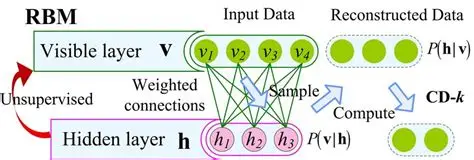

The "Restricted" part of the name is crucial:
- Nodes within the same layer are not connected (i.e., no visible-to-visible or hidden-to-hidden connections).
- Nodes are only connected between the two layers. This creates a bipartite graph.

What is a bipartite graph you may ask?
Well, a bipartite graph is a type of graph in which the set of vertices can be divided into *two disjoint subsets*, such that every edge connects a vertex from one subset to a vertex in the other subset. *No edges exist between vertices within the same subset*. Like below:

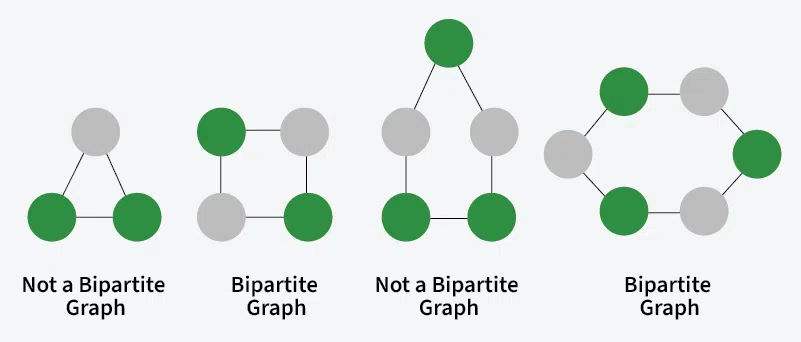

This restriction makes the model much easier to train. Because there are no connections within a layer, the states of all hidden nodes are conditionally independent given the visible nodes (and vice-versa). This allows for efficient training using an algorithm called Contrastive Divergence (CD-k).

In simple terms, training involves a three-step process:

1. Positive Phase: An input image (e.g., a "7") is shown to the visible layer. The RBM calculates the probabilities of the hidden nodes and activates them.
2. Negative Phase (Reconstruction): The model then attempts to "reconstruct" the original image using only the activated hidden nodes.
3. Weight Update: The RBM compares the original image to its reconstructed "fantasy" version. It then adjusts its weights to make the reconstructed image look more like the original.

## **What is the MNIST Dataset?**
The Modified National Institute of Standards and Technology (MNIST) dataset is the "hello, world!" of deep learning.

It is a large database of handwritten digits that is commonly used for training and testing machine learning models.

- Content - 70,000 grayscale images of handwritten digits from 0 to 9. Training set: 60,000 images, Test set: 10,000 images.

- Size - Each image is 28x28 pixels.

- Format - The 28x28 images are typically "flattened" into a 784-element vector (since 28 * 28 = 784) to be fed into a neural network.

## **Methodology**

To implement RBM on MNIST, we shall:

1. Data Preparation:

    - We will load the MNIST dataset.

    - The pixel values (0-255) will be normalized to a range of 0 to 1

    - We will binarize the data: pixels with a value > 0.5 will be set to 1 (on), and all others to 0 (off). This allows us to use a BernoulliRBM, which is designed for binary inputs.

2. Model Architecture:

    - Visible Layer: Will have 784 nodes, one for each pixel in the flattened MNIST image.

    - Hidden Layer: We will choose a number of hidden nodes (e.g., 256 or 512). This is a hyperparameter that determines the "representational capacity" of our model.

3. Training:

    - We will feed batches of the binarized MNIST images into the RBM.

    - The model will use the Contrastive Divergence algorithm to learn the weights that connect the visible and hidden layers.

    - The RBM's goal is to adjust these weights so it gets better and better at reconstructing the input digits.

First, we'll import the necessary libraries. We must use tensorflow.compat.v1 and disable_v2_behavior() because the RBM logic (placeholders, sessions) is written in TensorFlow 1.x style.

In [3]:
import tensorflow as tf # import machine learning library
import numpy as np # import data manupilation library
from tensorflow.keras.datasets import mnist # import the MNIST dataset through tensorflow

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

In [4]:
import tensorflow.compat.v1 as tf # machine learning library
tf.disable_v2_behavior()  # disables TF 2.x eager execution for TF 1.x code
import numpy as np # data manupilation library
import matplotlib.pyplot as plt # plotting library
from tensorflow.keras.datasets import mnist # import the MNIST dataset through tensorflow

print("Using TensorFlow Version:", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow Version: 2.19.0


### Load and Preprocess the MNIST Data


In [6]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten the images
# convert 28x28 images to 784-dimensional vectors
x_train = x_train.reshape(-1, 28 * 28).astype("float32")
x_test = x_test.reshape(-1, 28 * 28).astype("float32")

# normalize the data
# scale pixel values from [0, 255] to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# binarize the data and convert probabilities to binary 0 or 1.
# this RBM (BernoulliRBM) works on binary inputs.
x_train = np.round(x_train)
x_test = np.round(x_test)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Example data point (first 20 pixels):", x_train[0, :20])

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Example data point (first 20 pixels): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
class RBM():
    def __init__(self, nv=28*28, nh=512, cd_steps=3):
        """
        Initialize the RBM class.
        Args:
            nv (int): Number of visible units (784 for MNIST)
            nh (int): Number of hidden units (e.g., 512)
            cd_steps (int): Number of Gibbs sampling steps for Contrastive Divergence (CD-k)
        """
        self.graph = tf.Graph()
        with self.graph.as_default():
            # nv = number of visible units
            # nh = number of hidden units
            self.nv = nv
            self.nh = nh

            # --- Create Variables (Weights and Biases) ---
            # Weights connecting visible and hidden layers
            self.W = tf.Variable(tf.random.truncated_normal((nv, nh), stddev=0.01))
            # Bias for the visible layer
            self.bv = tf.Variable(tf.zeros((nv, 1)))
            # Bias for the hidden layer
            self.bh = tf.Variable(tf.zeros((nh, 1)))

            self.cd_steps = cd_steps
            self.modelW = None  # To store the trained weights later

    def bernoulli(self, p):
        """Sample from a Bernoulli distribution."""
        # tf.nn.relu and tf.sign create a binary (0 or 1) sample
        return tf.nn.relu(tf.sign(p - tf.random.uniform(tf.shape(p))))

    def energy(self, v):
        """Calculate the free energy of a visible sample."""
        # This is the core "energy function" of the RBM
        b_term = tf.matmul(v, self.bv)
        linear_transform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.nn.softplus(linear_transform), axis=1) # softplus is log(1 + exp(x))
        return tf.reduce_mean(-h_term - b_term)

    def sample_h(self, v):
        """Sample the hidden layer (h) given the visible layer (v)."""
        # Calculate the probability of hidden units being 'on'
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        # Sample from this probability
        return self.bernoulli(ph_given_v)

    def sample_v(self, h):
        """Sample the visible layer (v) given the hidden layer (h). (Reconstruction)"""
        # Calculate the probability of visible units being 'on'
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        # Sample from this probability
        return self.bernoulli(pv_given_h)

    def gibbs_step(self, i, k, vk):
        """A single step of Gibbs sampling (v -> h -> v')."""
        # Sample hidden units from visible
        hk = self.sample_h(vk)
        # Sample visible units from hidden (reconstruction)
        vk = self.sample_v(hk)
        return i+1, k, vk

    def train(self, X, lr=0.01, batch_size=64, epochs=5):
        """Train the RBM model."""
        with self.graph.as_default():
            # --- Setup the TF 1.x placeholders and graph ---
            # tf.placeholder is the TF 1.x way to feed data
            self.tf_v = tf.placeholder(tf.float32, [None, self.nv]) # Use None for flexible batch size

            # Binarize the input data
            v = tf.round(self.tf_v)
            vk = tf.identity(v)

            # --- Contrastive Divergence (CD-k) ---
            # Run the Gibbs chain for k (cd_steps) steps
            i = tf.constant(0)
            _, _, vk = tf.while_loop(cond = lambda i, k, *args: i < k, # Use < not <= for k steps
                                      body = self.gibbs_step,
                                      loop_vars = [i, tf.constant(self.cd_steps), vk],
                                      parallel_iterations=1,
                                      back_prop=False)

            # Stop gradient to prevent backprop through the Gibbs chain
            vk = tf.stop_gradient(vk)

            # --- Loss Function (Energy difference) ---
            # We want to minimize the energy of the real data
            # and maximize the energy of the "fantasy" (reconstructed) data
            loss = self.energy(v) - self.energy(vk)

            # --- Optimizer ---
            optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

            # Initialize all variables
            init = tf.global_variables_initializer()

        # --- Run the TF 1.x Session ---
        with tf.Session(graph=self.graph) as sess:
            init.run()
            for epoch in range(epochs):
                losses = []
                # Loop over the data in batches
                for i in range(0, len(X) - batch_size, batch_size):
                    x_batch = X[i:i + batch_size]
                    # Run the optimizer and loss nodes
                    l, _ = sess.run([loss, optimizer], feed_dict={self.tf_v: x_batch})
                    losses.append(l)

                print(f"Epoch {epoch+1}/{epochs}, Mean Loss: {np.mean(losses):.4f}")

            # Training complete, store the learned weights
            self.modelW = self.W.eval()
            self.model_bv = self.bv.eval()
            self.model_bh = self.bh.eval()
            print("Training Complete.")

Now we create an instance of our RBM and train it on the x_train data we prepared.

In [13]:
# --- Parameters ---
N_VISIBLE = 784    # Number of visible units
N_HIDDEN = 512    # Number of hidden feature detectors
CD_K = 2          # Number of Gibbs steps
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 128

# --- Create and Train ---
rbm = RBM(nv=N_VISIBLE, nh=N_HIDDEN, cd_steps=CD_K)

rbm.train(X=x_train, lr=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20, Mean Loss: -16.2678
Epoch 2/20, Mean Loss: -14.0205
Epoch 3/20, Mean Loss: -14.1664
Epoch 4/20, Mean Loss: -13.7596
Epoch 5/20, Mean Loss: -12.7155
Epoch 6/20, Mean Loss: -11.7719
Epoch 7/20, Mean Loss: -10.8139
Epoch 8/20, Mean Loss: -9.9958
Epoch 9/20, Mean Loss: -9.2175
Epoch 10/20, Mean Loss: -8.5841
Epoch 11/20, Mean Loss: -8.0522
Epoch 12/20, Mean Loss: -7.5542
Epoch 13/20, Mean Loss: -6.9821
Epoch 14/20, Mean Loss: -6.6347
Epoch 15/20, Mean Loss: -6.2311
Epoch 16/20, Mean Loss: -5.8532
Epoch 17/20, Mean Loss: -5.5611
Epoch 18/20, Mean Loss: -5.3301
Epoch 19/20, Mean Loss: -5.1058
Epoch 20/20, Mean Loss: -4.8444
Training Complete.


#### Visualize the Learned Features (Weights)
The most insightful part of an RBM is looking at what it "learned." This can be done by plotting the weights (W) associated with each hidden unit.

Each hidden unit is connected to all 784 visible pixels, so we can reshape its 784 weights back into a 28x28 image to see what feature it has learned to detect.

Visualizing Learned Features (Weights)...


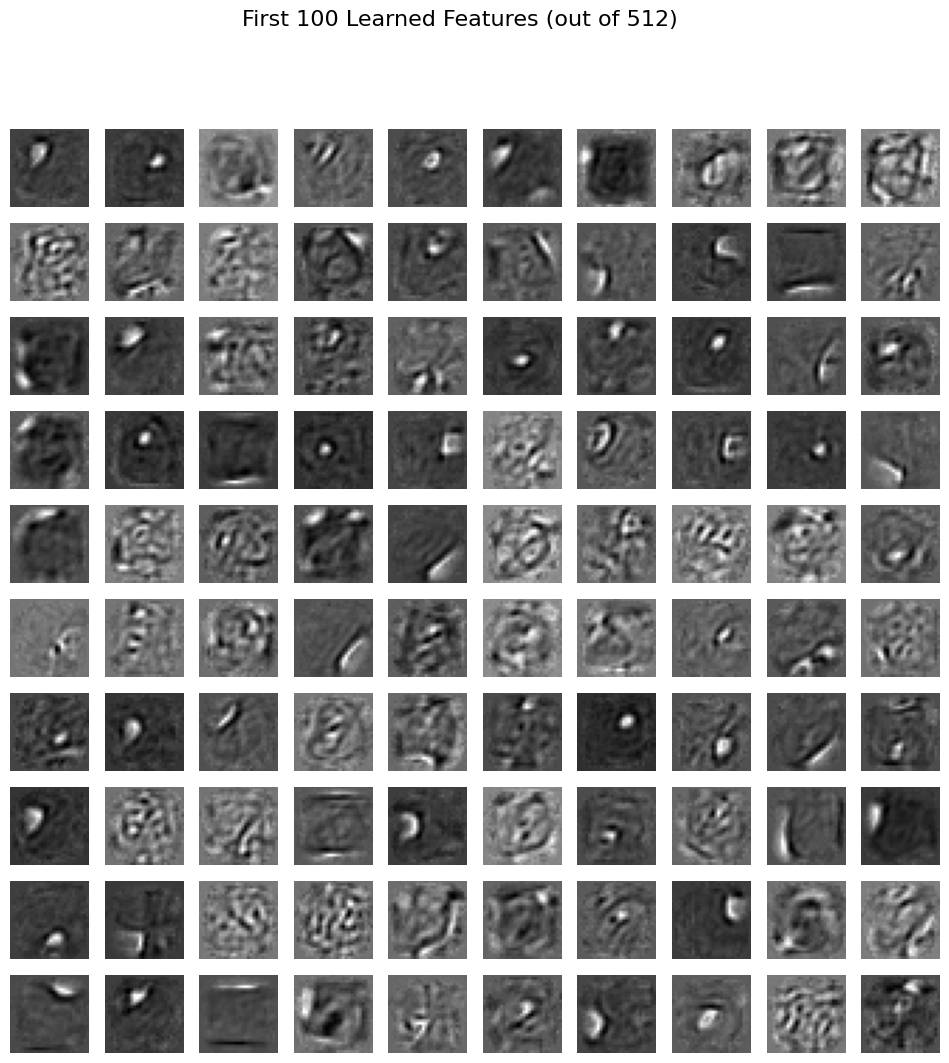

In [14]:
print("Visualizing Learned Features (Weights)...")

# Get the trained weights (shape: N_VISIBLE, N_HIDDEN)
weights = rbm.modelW

# Create a grid to plot the filters
plt.figure(figsize=(12, 12))
for i in range(100): # Plot the first 100 features
    plt.subplot(10, 10, i + 1)

    # Get the weights for the i-th hidden node and reshape
    # We transpose weights to (N_HIDDEN, 784) then pick the i-th row
    feature = weights.T[i].reshape(28, 28)

    plt.imshow(feature, cmap='binary')
    plt.axis('off')

plt.suptitle(f"First 100 Learned Features (out of {N_HIDDEN})", fontsize=16)
plt.show()

#### Visualize Reconstructions
Let's see how well the RBM can reconstruct digits from the test set. We will:
1. Take a batch of test images.
2. Pass them to the RBM (v).
3. Sample the hidden layer (h).
4. Reconstruct the visible layer (v_reconstructed) from the hidden sample.
5. Plot the originals and their reconstructions side-by-side.

Visualizing Reconstructions...


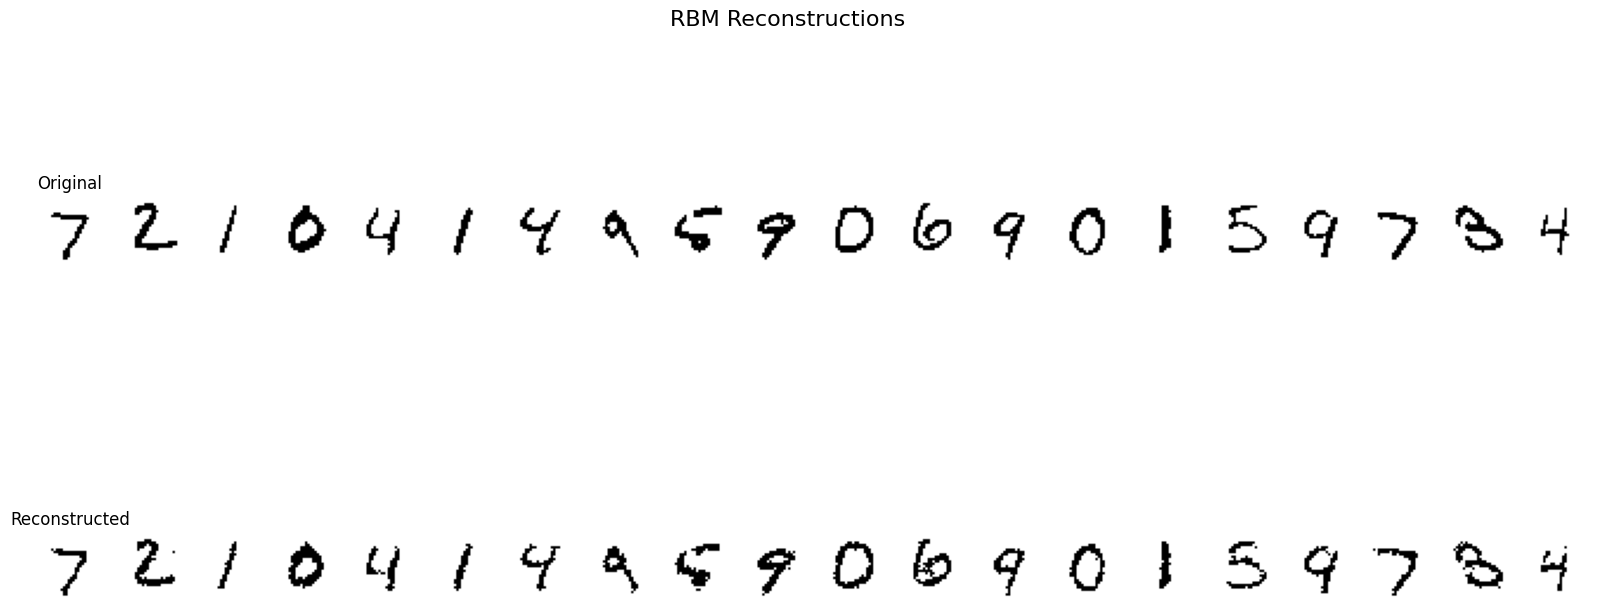

In [15]:
print("Visualizing Reconstructions...")

# Use the trained RBM in its graph
with tf.Session(graph=rbm.graph) as sess:
    # Restore the trained variables
    sess.run(rbm.W.assign(rbm.modelW))
    sess.run(rbm.bv.assign(rbm.model_bv))
    sess.run(rbm.bh.assign(rbm.model_bh))

    # Get a batch of test data
    n_images = 20
    test_batch = x_test[:n_images]

    # Run the v -> h -> v' reconstruction
    # We need to find the graph's input placeholder
    tf_v = rbm.graph.get_tensor_by_name(rbm.tf_v.name)

    # 1. Sample hidden from visible
    h_sample = rbm.sample_h(tf_v)
    # 2. Reconstruct visible from hidden
    v_reconstruction = rbm.sample_v(h_sample)

    # Run the operation
    reconstructed_imgs = sess.run(v_reconstruction, feed_dict={tf_v: test_batch})

# --- Plot the results ---
plt.figure(figsize=(20, 8))
for i in range(n_images):
    # Plot Original
    plt.subplot(2, n_images, i + 1)
    plt.imshow(test_batch[i].reshape(28, 28), cmap='binary')
    if i == 0:
        plt.title("Original")
    plt.axis('off')

    # Plot Reconstruction
    plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='binary')
    if i == 0:
        plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("RBM Reconstructions", fontsize=16)
plt.show()